# Pbar for the Globe

Goal for this notebook is to take the work I did looking at a small section and apply it to global calculations. Let's see how it goes.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load Data

In [11]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc').rename({'PRES_INTERPOLATED':'pressure','N_PROF':'prof','LATITUDE':'lat','LONGITUDE':'lon'})   

## Coord interp to rho (density)

In [5]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [6]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='N_PROF', dim2='PRES'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF', 'rho_grid'],
            coords={'rho_grid': rho_grid, 'N_PROF': ds_z.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    ds_rho = ds_rho.assign_coords(LATITUDE  =(dim1, ds_z.LATITUDE.data))
    ds_rho = ds_rho.assign_coords(LONGITUDE =(dim1, ds_z.LONGITUDE.data))
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [7]:
ds_rho = get_ds_rho(ds_p, ds_p.SIG0, np.arange(21,29,0.0025), ['CT','SA','SIG0','SPICE','PRES'], dim2='PRES_INTERPOLATED')

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES
Completed merge


In [16]:
ds_rho = ds_rho.rename({'N_PROF':'prof','rho_grid':'density'})

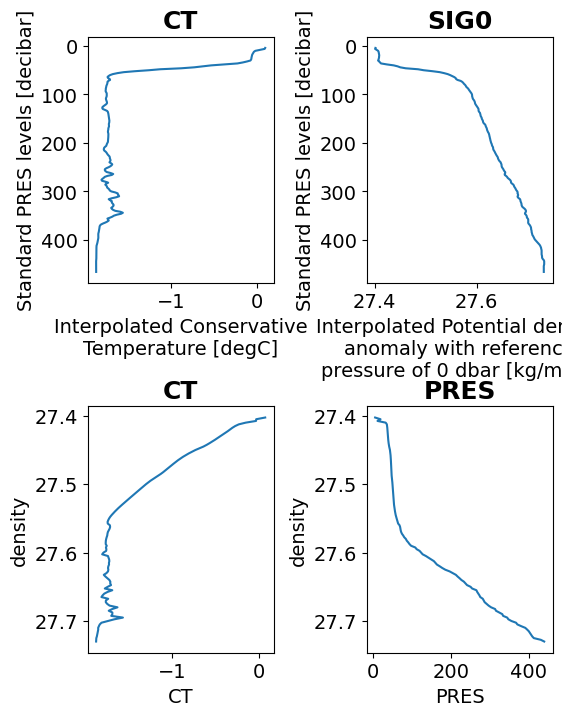

In [26]:
num = 70
prof_p = ds_p.isel(prof=num)
prof_rho = ds_rho.isel(prof=num)

plt.figure(figsize=(6,8))
plt.subplot(221)
prof_p.CT.plot(y='pressure')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(222)
prof_p.SIG0.plot(y='pressure')
plt.gca().invert_yaxis()
plt.title('SIG0')

plt.subplot(223)
prof_rho.CT.plot(y='density')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(224)
prof_rho.PRES.plot(y='density')
plt.gca().invert_yaxis()
plt.title('PRES')

plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [28]:
ds_rho.to_netcdf('/swot/SUM05/amf2288/res_2.5/ds_r.nc')

In [29]:
ds_rho = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_r.nc')

## Coord interp to pmean (average isopycnal depth)

## Add mean pressure variable

In [335]:
def match_mean_profiles(ds_rho, pres_rho_gridded):
    lat_bins = pres_rho_gridded.lat_left.values
    lon_bins = pres_rho_gridded.lon_left.values

    lat_idx = np.digitize(ds_rho.LATITUDE.values, lat_bins) - 1
    lon_idx = np.digitize(ds_rho.LONGITUDE.values, lon_bins) - 1

    valid = (lat_idx >= 0) & (lat_idx < len(pres_rho_gridded.lat)) & \
            (lon_idx >= 0) & (lon_idx < len(pres_rho_gridded.lon))

    matched_profiles = np.full((ds_rho.dims['N_PROF'], ds_rho.dims['rho_grid']), np.nan, dtype=np.float32)
    matched_profiles[valid] = pres_rho_gridded.PRES.values[:, lon_idx[valid], lat_idx[valid]].T

    return xr.DataArray(matched_profiles, dims=('N_PROF', 'rho_grid'),
                        coords={'N_PROF': ds_rho.N_PROF, 'rho_grid': ds_rho.rho_grid})

In [365]:
ds_rho['pres_dens'] = match_mean_profiles(ds_rho, pres_rho_gridded)

/tmp/ipykernel_62437/2532508881.py:11: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  matched_profiles = np.full((ds_rho.dims['N_PROF'], ds_rho.dims['rho_grid']), np.nan, dtype=np.float32)


In [11]:
num = 309876
prof = ds_rho.isel(N_PROF=num)
mean = pres_rho_gridded.sel(lat=prof.LATITUDE, method='nearest').sel(lon=prof.LONGITUDE, method='nearest')
print(f'PROF lat: {prof.LATITUDE.values}, lon: {prof.LONGITUDE.values}')
print(f'MEAN lat: {mean.lat.values}, lon: {mean.lon.values}')

plt.figure(figsize=(4,6))
prof.PRES.plot(y='rho_grid', label='profile')
prof.pres_dens.plot(y='rho_grid',  label='mean profile')
mean.PRES.plot(y='density', label='pres_rho')
plt.legend();

NameError: name 'pres_rho_gridded' is not defined

In [382]:
from scipy.ndimage import uniform_filter1d

def interp_to_pmean(var_profile, pres_dens, pmean_grid, roll=50):
    try:
        # Apply a centered moving average using a uniform filter
        pmean_smooth = uniform_filter1d(pres_dens, size=roll, mode='nearest', origin=0)

        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        return np.full_like(pmean_grid, np.nan)

In [383]:
#ds_p_gridded = get_ds_gridded(ds_p.rename({'LONGITUDE':'lon','LATITUDE':'lat'}), lon_bins, lat_bins)

In [384]:
#ds_p_gridded.CT.sel(PRES_INTERPOLATED=500, method='nearest').plot(x='LONGITUDE',y='LATITUDE',cmap=cmo.thermal)

In [385]:
#pmean.CT.sel(pmean=500, method='nearest').plot(x='lon',y='lat',cmap=cmo.thermal)

In [386]:
def get_ds_pmean(ds_rho, pmean_grid, variables, roll=50):
    
    xrs = []
    pmean_size = pmean_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], ds_rho['pres_dens'],
                                   input_core_dims=[['rho_grid'], ['rho_grid']],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid, 'roll':roll},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=['N_PROF','pmean_grid'],
            coords={'pmean_grid': pmean_grid, 'N_PROF': ds_rho.N_PROF},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(lat  = ('N_PROF', ds_rho.LATITUDE.data))
    ds_pmean = ds_pmean.assign_coords(lon = ('N_PROF', ds_rho.LONGITUDE.data))
    #ds_pmean = ds_pmean.assign_coords(TIME      = ('N_PROF', ds_rho.TIME.data))
    
    return ds_pmean

In [28]:
%%time
CT_pmean = get_ds_pmean(ds_rho, np.linspace(0,2000,1001), ['CT'], roll=50)

CPU times: user 36 μs, sys: 8 μs, total: 44 μs
Wall time: 65.6 μs


NameError: name 'get_ds_pmean' is not defined

In [414]:
%%time
CT_pmean.to_netcdf('/swot/SUM05/amf2288/CT_pmean_10_30_bintry.nc')

CPU times: user 71.2 ms, sys: 10.1 s, total: 10.2 s
Wall time: 12.5 s


In [415]:
%%time
SA_pmean = get_ds_pmean(ds_rho, np.linspace(0,2000,1001), ['SA'], roll=100)

Completed comp for SA
Completed SA
Completed merge
CPU times: user 3min 14s, sys: 16.3 s, total: 3min 30s
Wall time: 3min 30s


In [416]:
%%time
SA_pmean.to_netcdf('/swot/SUM05/amf2288/SA_pmean_10_30_bintry.nc')

CPU times: user 89.8 ms, sys: 8.76 s, total: 8.85 s
Wall time: 11.8 s


In [417]:
%%time
SP_pmean = get_ds_pmean(ds_rho, np.linspace(0,2000,1001), ['SPICE'], roll=10)

Completed comp for SPICE
Completed SPICE
Completed merge
CPU times: user 2min 12s, sys: 17.1 s, total: 2min 29s
Wall time: 2min 29s


In [418]:
%%time
SP_pmean.to_netcdf('/swot/SUM05/amf2288/SP_pmean_10_30_bintry.nc')

CPU times: user 32.1 ms, sys: 11.1 s, total: 11.1 s
Wall time: 12.2 s


In [30]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    # Step 1: Reduce using flox
    ds_binned = xarray_reduce(
        ds,
        'lon',
        'lat',
        func='mean',
        expected_groups=(
            pd.IntervalIndex.from_breaks(lon_bins),
            pd.IntervalIndex.from_breaks(lat_bins)
        ),
        fill_value=np.nan,
        skipna=True
    )

    # Step 2: Rename dimensions and variables
    ds_binned = ds_binned.rename_dims({
        'lon_bins': 'lon',
        'lat_bins': 'lat',}).rename_vars({
        #'rho_grid': 'density'
        'lon_bins': 'lon',
        'lat_bins': 'lat',
        #'rho_grid': 'density'
    })

    # Step 3: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 4: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'density'}
    }, periodic=['X'])

    return ds_gridded, grid

In [14]:
ds_p = ds_p.rename({'PRES_INTERPOLATED':'pres','N_PROF':'prof','LATITUDE':'lat','LONGITUDE':'lon'})

In [34]:
lon_bins3 = np.arange(-180,181,3)
lat_bins3 = np.arange(-88.5,89,3)

lon_bins1 = np.arange(-180,181,1)
lat_bins1 = np.arange(-89.5,89.5,1)

In [19]:
ds_p_grid3, grid = get_ds_gridded(ds_p, lon_bins3, lat_bins3)
ds_p_grid3.to_netcdf('/swot/SUM05/amf2288/res_2.5/ds_p_grid3.nc')

In [20]:
ds_p_grid1, grid = get_ds_gridded(ds_p, lon_bins1, lat_bins1)
ds_p_grid1.to_netcdf('/swot/SUM05/amf2288/res_2.5/ds_p_grid1.nc')

In [22]:
ds_rho = ds_rho.rename({'rho_grid':'density','N_PROF':'prof','LATITUDE':'lat','LONGITUDE':'lon'})

In [32]:
ds_r = ds_rho

In [37]:
ds_r = ds_r.rename({'LATITUDE':'lat','LONGITUDE':'lon'})

In [38]:
ds_r_grid3, grid = get_ds_gridded(ds_r, lon_bins3, lat_bins3)
ds_r_grid3.to_netcdf('/swot/SUM05/amf2288/res_2.5/ds_r_grid3.nc')

In [39]:
ds_r_grid1, grid = get_ds_gridded(ds_r, lon_bins1, lat_bins1)
ds_r_grid1.to_netcdf('/swot/SUM05/amf2288/res_2.5/ds_r_grid1.nc')

In [290]:
pres_rho = xr.Dataset({'PRES':ds_rho.PRES}).rename({'LONGITUDE':'lon','LATITUDE':'lat'})

In [292]:
pres_rho_gridded, grid = get_ds_gridded(pres_rho, lon_bins, lat_bins)

In [271]:
CT_pmean = xr.open_dataset('/swot/SUM05/amf2288/CT_pmean_10_30.nc')
SA_pmean = xr.open_dataset('/swot/SUM05/amf2288/SA_pmean_10_30.nc')
SP_pmean = xr.open_dataset('/swot/SUM05/amf2288/SP_pmean_10_30.nc')

In [437]:
CT_pmean_grid, grid = get_ds_gridded(CT_pmean.rename({'pmean_grid':'pmean'}), lon_bins, lat_bins)
SA_pmean_grid, grid = get_ds_gridded(SA_pmean.rename({'pmean_grid':'pmean'}), lon_bins, lat_bins)
SP_pmean_grid, grid = get_ds_gridded(SP_pmean.rename({'pmean_grid':'pmean'}), lon_bins, lat_bins)

In [438]:
ds_pmean_grid = xr.merge([CT_pmean_grid, SA_pmean_grid, SP_pmean_grid])
ds_pmean_grid

<xarray.Dataset> Size: 170MB
Dimensions:   (pmean: 1001, lon: 120, lat: 59, lon_left: 120, lat_left: 59)
Coordinates:
  * pmean     (pmean) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * lon       (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * lat       (lat) float64 472B -87.0 -84.0 -81.0 -78.0 ... 78.0 81.0 84.0 87.0
  * lon_left  (lon_left) float64 960B -180.0 -177.0 -174.0 ... 171.0 174.0 177.0
  * lat_left  (lat_left) float64 472B -88.5 -85.5 -82.5 -79.5 ... 79.5 82.5 85.5
Data variables:
    CT        (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    SA        (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    SPICE     (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan

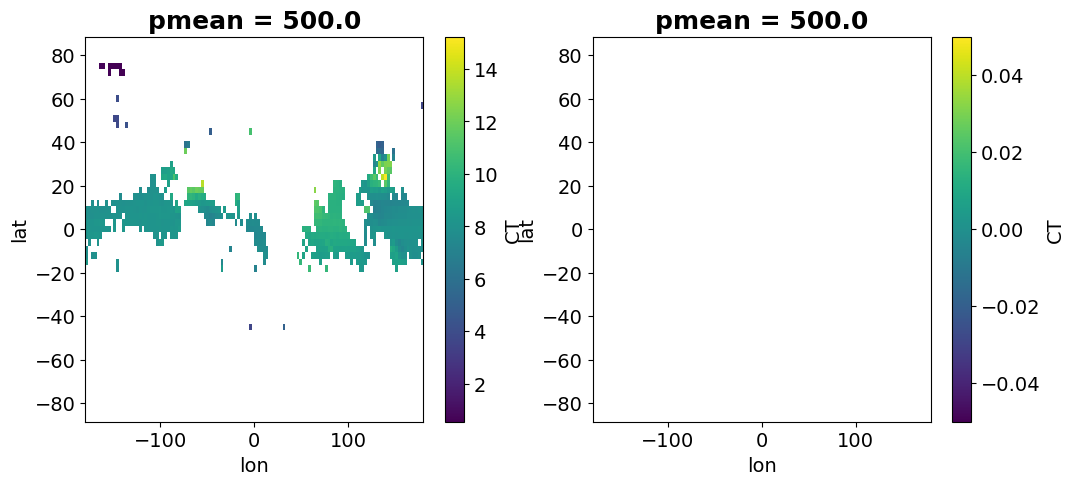

In [442]:
plt.figure(figsize=(12,5))

plt.subplot(121)
ds_pmean_grid.CT.sel(pmean=500, method='nearest').plot(x='lon',y='lat')

plt.subplot(122)
ds_pmean_regional_grid.CT.sel(pmean=500, method='nearest').plot(x='lon',y='lat')

## Calculations on pmean surfaces

In [21]:
lfilt=100

ct_m = ff.ds_filt_single(ds_pmean, lfilt, variable='CT', dim1='prof', dim2='pmean')
sa_m = ff.ds_filt_single(ds_pmean, lfilt, variable='SA', dim1='prof', dim2='pmean')
sp_m = ff.ds_filt_single(ds_pmean, lfilt, variable='SPICE', dim1='prof', dim2='pmean')

In [22]:
ct_e = ds_pmean.CT - ct_m
sa_e = ds_pmean.SA - sa_m
sp_e = ds_pmean.SPICE - sp_m

In [23]:
ct_e_z2 = ct_e.differentiate(coord='pmean')**2
sa_e_z2 = sa_e.differentiate(coord='pmean')**2
sp_e_z2 = sp_e.differentiate(coord='pmean')**2

In [37]:
#mesoscale variance
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt, dim1='prof', dim2='pmean')
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt, dim1='prof', dim2='pmean')
sp_e_z2_filt = ff.da_filt_single(sp_e_z2, lfilt, dim1='prof', dim2='pmean')

In [38]:
#microscale variance
ct_m_z2 = ct_m.differentiate(coord='pmean')**2
sa_m_z2 = sa_m.differentiate(coord='pmean')**2
sp_m_z2 = sp_m.differentiate(coord='pmean')**2

In [39]:
ct_e_z2_filt = ct_e_z2_filt.to_dataset(name='ct_e_z2_filt')
sa_e_z2_filt = sa_e_z2_filt.to_dataset(name='sa_e_z2_filt')
sp_e_z2_filt = sp_e_z2_filt.to_dataset(name='sp_e_z2_filt')

ct_m_z2 = ct_m_z2.to_dataset(name='ct_m_z2')
sa_m_z2 = sa_m_z2.to_dataset(name='sa_m_z2')
sp_m_z2 = sp_m_z2.to_dataset(name='sp_m_z2')

In [40]:
ct_e_z2_filt_grid, grid = get_ds_gridded(ct_e_z2_filt, lon_bins, lat_bins)
sa_e_z2_filt_grid, grid = get_ds_gridded(sa_e_z2_filt, lon_bins, lat_bins)
sp_e_z2_filt_grid, grid = get_ds_gridded(sp_e_z2_filt, lon_bins, lat_bins)

ct_m_z2_grid, grid = get_ds_gridded(ct_m_z2, lon_bins, lat_bins)
sa_m_z2_grid, grid = get_ds_gridded(sa_m_z2, lon_bins, lat_bins)
sp_m_z2_grid, grid = get_ds_gridded(sp_m_z2, lon_bins, lat_bins)

In [48]:
K_rho_x = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc').K.drop_vars(['z_l','z_r','lon_r','lat_r']).rename({'lon_l':'lon_left','lat_l':'lat_left','z_c':'pmean','lat_c':'lat','lon_c':'lon'})

In [51]:
K_rho_x = K_rho_x.interp(pmean=ct_e_z2_filt_grid.pmean)

In [70]:
ct_var2 = ct_e_z2_filt_grid.rename({'ct_e_z2_filt':'ct_var2'})
sa_var2 = sa_e_z2_filt_grid.rename({'sa_e_z2_filt':'sa_var2'})
sp_var2 = sp_e_z2_filt_grid.rename({'sp_e_z2_filt':'sp_var2'})

ct_var3 = ct_m_z2_grid.rename({'ct_m_z2':'ct_var3'})
sa_var3 = sa_m_z2_grid.rename({'sa_m_z2':'sa_var3'})
sp_var3 = sp_m_z2_grid.rename({'sp_m_z2':'sp_var3'})

ct2_VPR = (K_rho_x*ct_var2).rename({'ct_var2':'ct2_VPR'})
sa2_VPR = (K_rho_x*sa_var2).rename({'sa_var2':'sa2_VPR'})
sp2_VPR = (K_rho_x*sp_var2).rename({'sp_var2':'sp2_VPR'})

ct3_VPR = (K_rho_x*ct_var3).rename({'ct_var3':'ct3_VPR'})
sa3_VPR = (K_rho_x*sa_var3).rename({'sa_var3':'sa3_VPR'})
sp3_VPR = (K_rho_x*sp_var3).rename({'sp_var3':'sp3_VPR'})

In [165]:
ct2_frac = ((ct_var2.ct_var2)/(ct_var2.ct_var2 + ct_var3.ct_var3)).rename('ct2_frac')
sa2_frac = ((sa_var2.sa_var2)/(sa_var2.sa_var2 + sa_var3.sa_var3)).rename('sa2_frac')
sp2_frac = ((sp_var2.sp_var2)/(sp_var2.sp_var2 + sp_var3.sp_var3)).rename('sp2_frac')

In [238]:
pmean = xr.merge([K_rho_x.rename('K_rho'),
                  CT_pmean_grid, SA_pmean_grid, SP_pmean_grid,
                  ct_var2, sa_var2, sp_var2,
                  ct_var3, sa_var3, sp_var3,
                  ct2_VPR, sa2_VPR, sp2_VPR,
                  ct3_VPR, sa3_VPR, sp3_VPR,
                  ct2_frac,sa2_frac,sp2_frac,
                  K_e_ct,  K_e_sa,  K_e_sp])

In [239]:
pmean

<xarray.Dataset> Size: 1GB
Dimensions:   (lat: 59, lon: 120, pmean: 1001, lon_left: 120, lat_left: 59)
Coordinates:
  * lat       (lat) float64 472B -87.0 -84.0 -81.0 -78.0 ... 78.0 81.0 84.0 87.0
  * lon       (lon) float64 960B -178.5 -175.5 -172.5 ... 172.5 175.5 178.5
  * pmean     (pmean) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * lon_left  (lon_left) float64 960B -180.0 -177.0 -174.0 ... 171.0 174.0 177.0
  * lat_left  (lat_left) float64 472B -88.5 -85.5 -82.5 -79.5 ... 79.5 82.5 85.5
Data variables: (12/22)
    K_rho     (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    CT        (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    SA        (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    SPICE     (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    ct_var2   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    sa_var2   (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    ...        ...
    ct2_frac  (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    sa2_frac  (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    sp2_frac  (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    K_e_ct    (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    K_e_sa    (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan
    K_e_sp    (pmean, lon, lat) float64 57MB nan nan nan nan ... nan nan nan nan

In [240]:
pmean.to_netcdf('/swot/SUM05/amf2288/pmean_frac_K_e.nc')

## Variance Production Maps

In [241]:
pmean = xr.open_dataset('/swot/SUM05/amf2288/pmean_frac_K_e.nc')

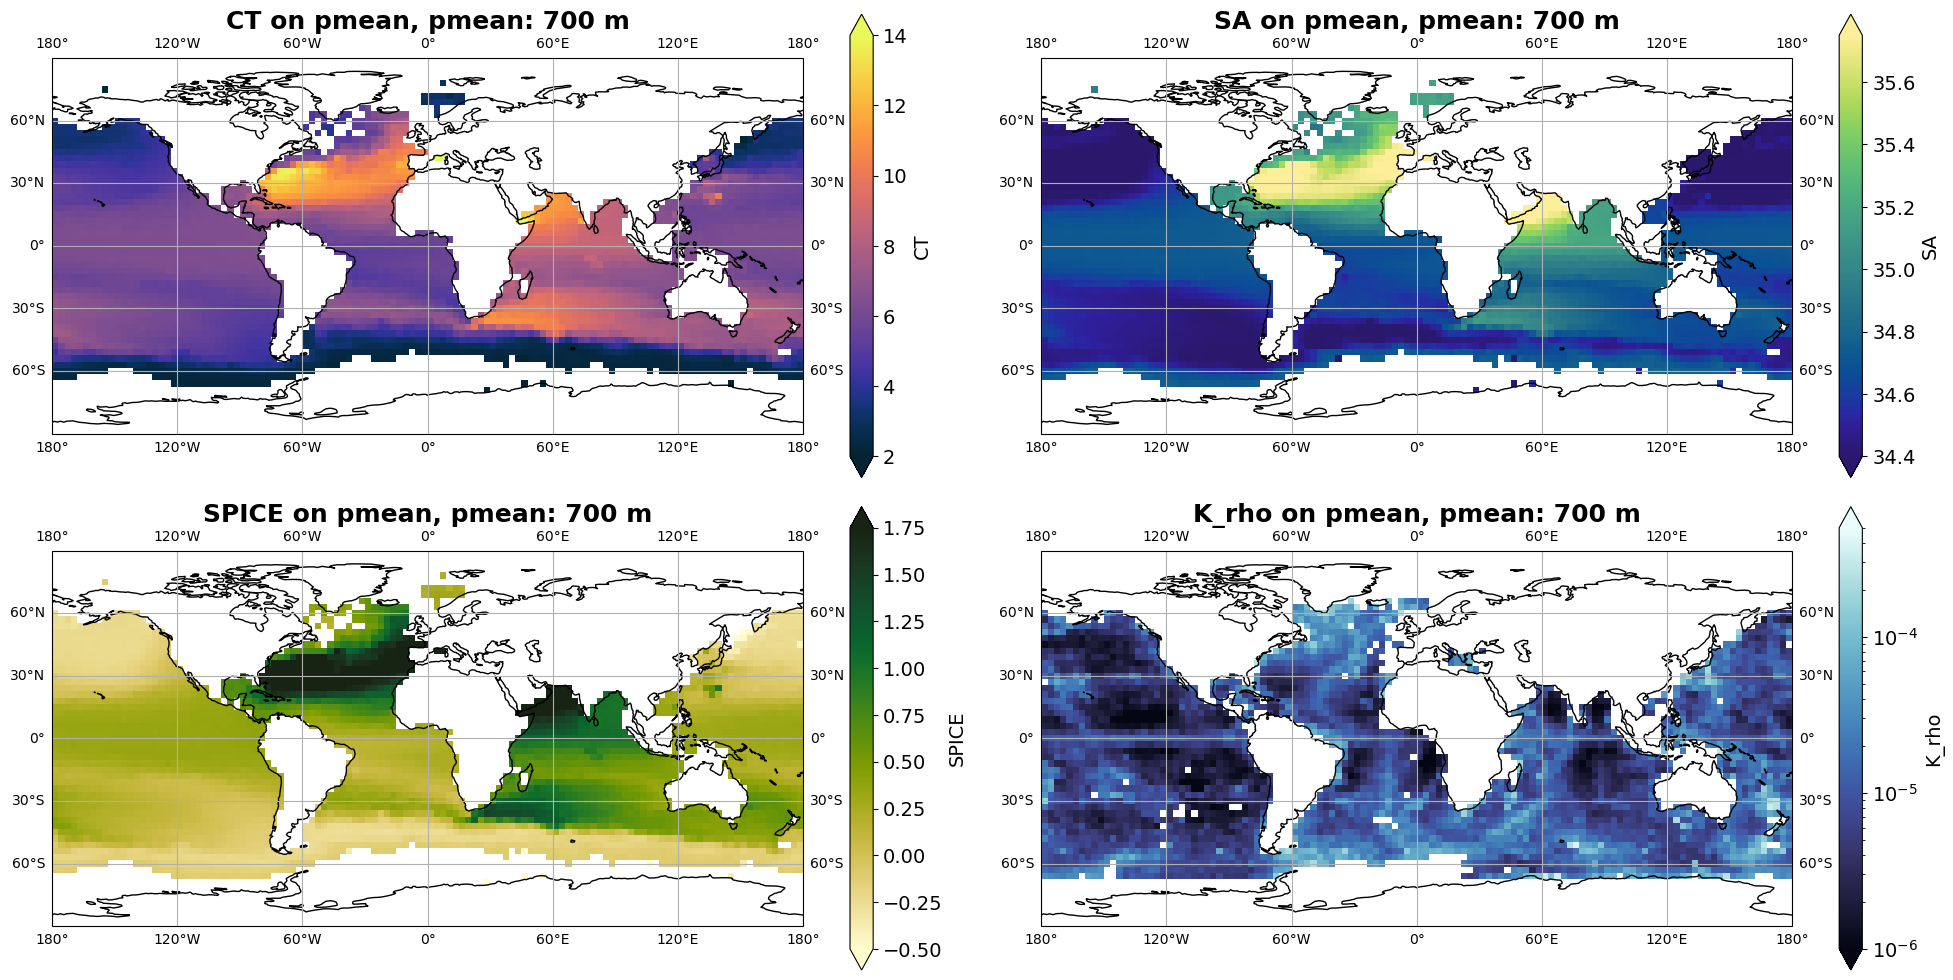

In [245]:
depth = 700

ct_cmap, sa_cmap, sp_cmap, K_cmap = cmo.thermal, cmo.haline, cmo.speed, cmo.ice
ct_norm = colors.Normalize(vmin=2, vmax=14)
sa_norm = colors.Normalize(vmin=34.4, vmax=35.75)
sp_norm = colors.Normalize(vmin=-0.5, vmax=1.75)
K_norm = colors.LogNorm(vmin=1e-6, vmax=5e-4)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10),subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten() # Flatten axes for easy iteration

ax = axes[0]
pmean.sel(pmean=depth, method='nearest').CT.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=ct_cmap, norm=ct_norm)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'CT on pmean, pmean: {depth} m')

ax = axes[1]
pmean.sel(pmean=depth, method='nearest').SA.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=sa_cmap, norm=sa_norm)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SA on pmean, pmean: {depth} m')

ax = axes[2]
pmean.sel(pmean=depth, method='nearest').SPICE.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=sp_cmap, norm=sp_norm)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SPICE on pmean, pmean: {depth} m')

ax = axes[3]
pmean.sel(pmean=depth, method='nearest').K_rho.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=K_cmap, norm=K_norm)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'K_rho on pmean, pmean: {depth} m')


plt.tight_layout()
plt.show()

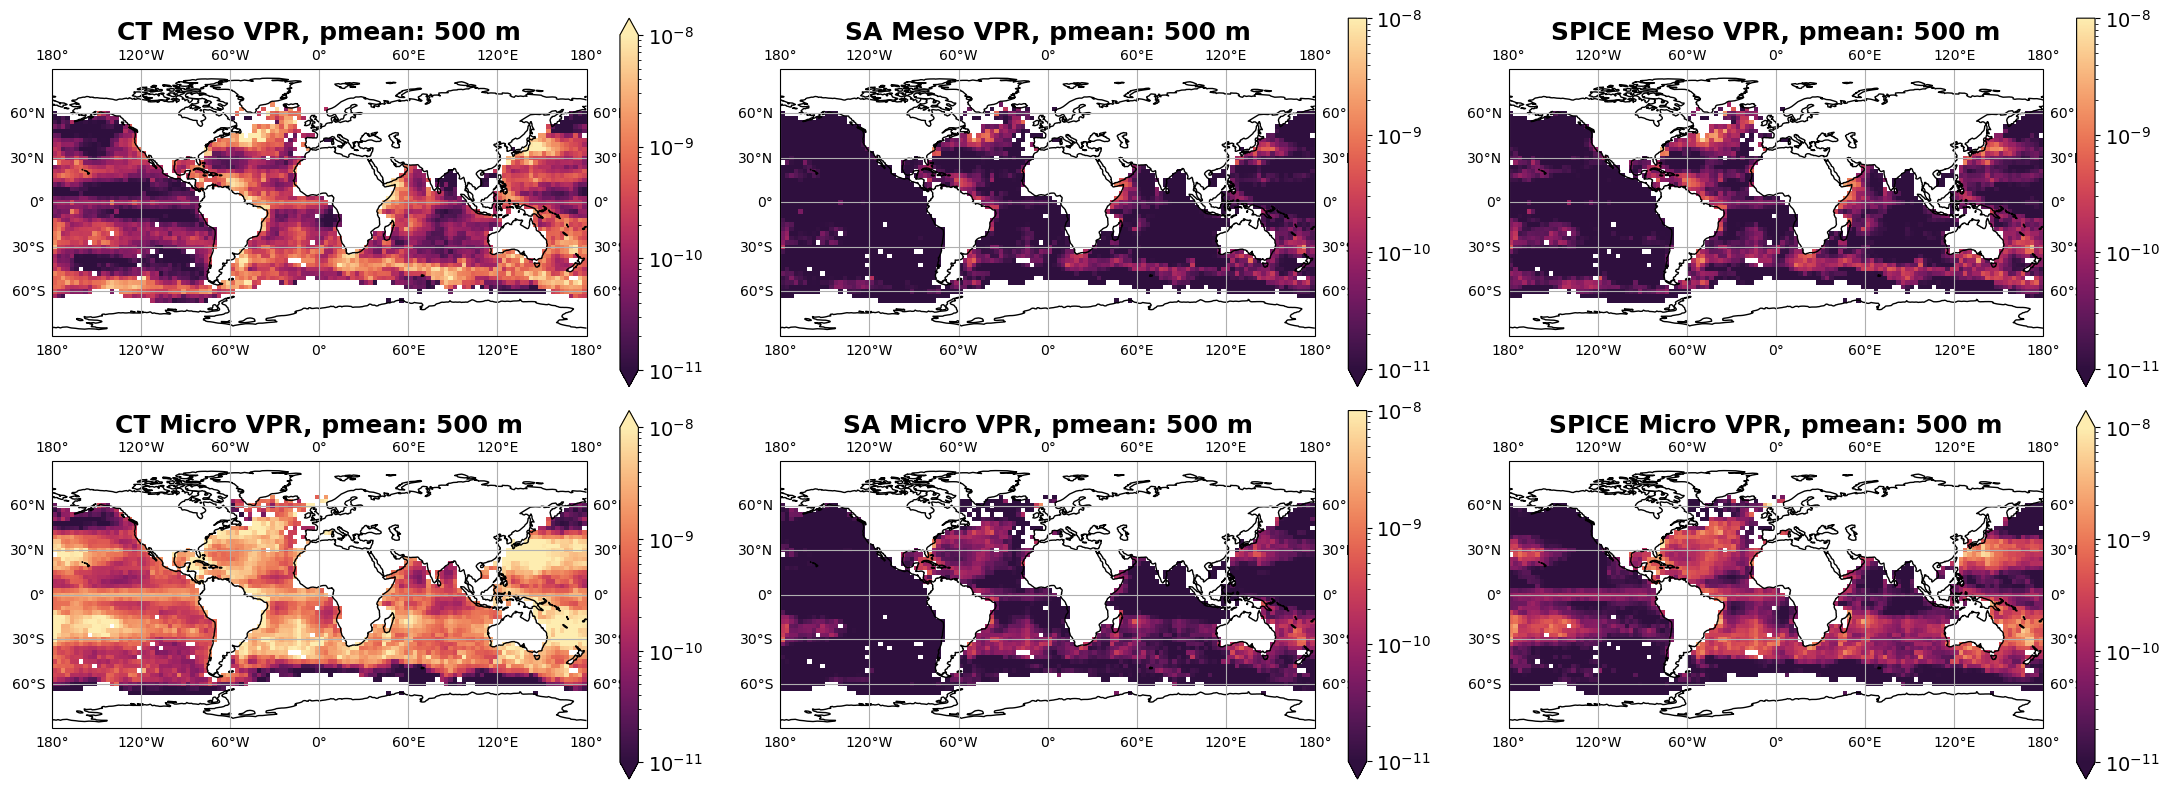

In [250]:
depth = 500

var2_map, var3_map = cmo.matter_r, cmo.matter_r
var2_norm = colors.LogNorm(vmin=1e-11, vmax=1e-8)
var3_norm = colors.LogNorm(vmin=1e-11, vmax=1e-8)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 8),subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten() # Flatten axes for easy iteration

ax = axes[0]
pmean.sel(pmean=depth, method='nearest').ct2_VPR.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=var2_map, norm=var2_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'CT Meso VPR, pmean: {depth} m')

ax = axes[1]
pmean.sel(pmean=depth, method='nearest').sa2_VPR.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=var2_map, norm=var2_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SA Meso VPR, pmean: {depth} m')

ax = axes[2]
pmean.sel(pmean=depth, method='nearest').sp2_VPR.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=var2_map, norm=var2_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SPICE Meso VPR, pmean: {depth} m')

ax = axes[3]
pmean.sel(pmean=depth, method='nearest').ct3_VPR.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=var3_map, norm=var3_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'CT Micro VPR, pmean: {depth} m')

ax = axes[4]
pmean.sel(pmean=depth, method='nearest').sa3_VPR.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=var3_map, norm=var3_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SA Micro VPR, pmean: {depth} m')

ax = axes[5]
pmean.sel(pmean=depth, method='nearest').sp3_VPR.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=var3_map, norm=var3_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SPICE Micro VPR, pmean: {depth} m')


plt.tight_layout()
plt.show()

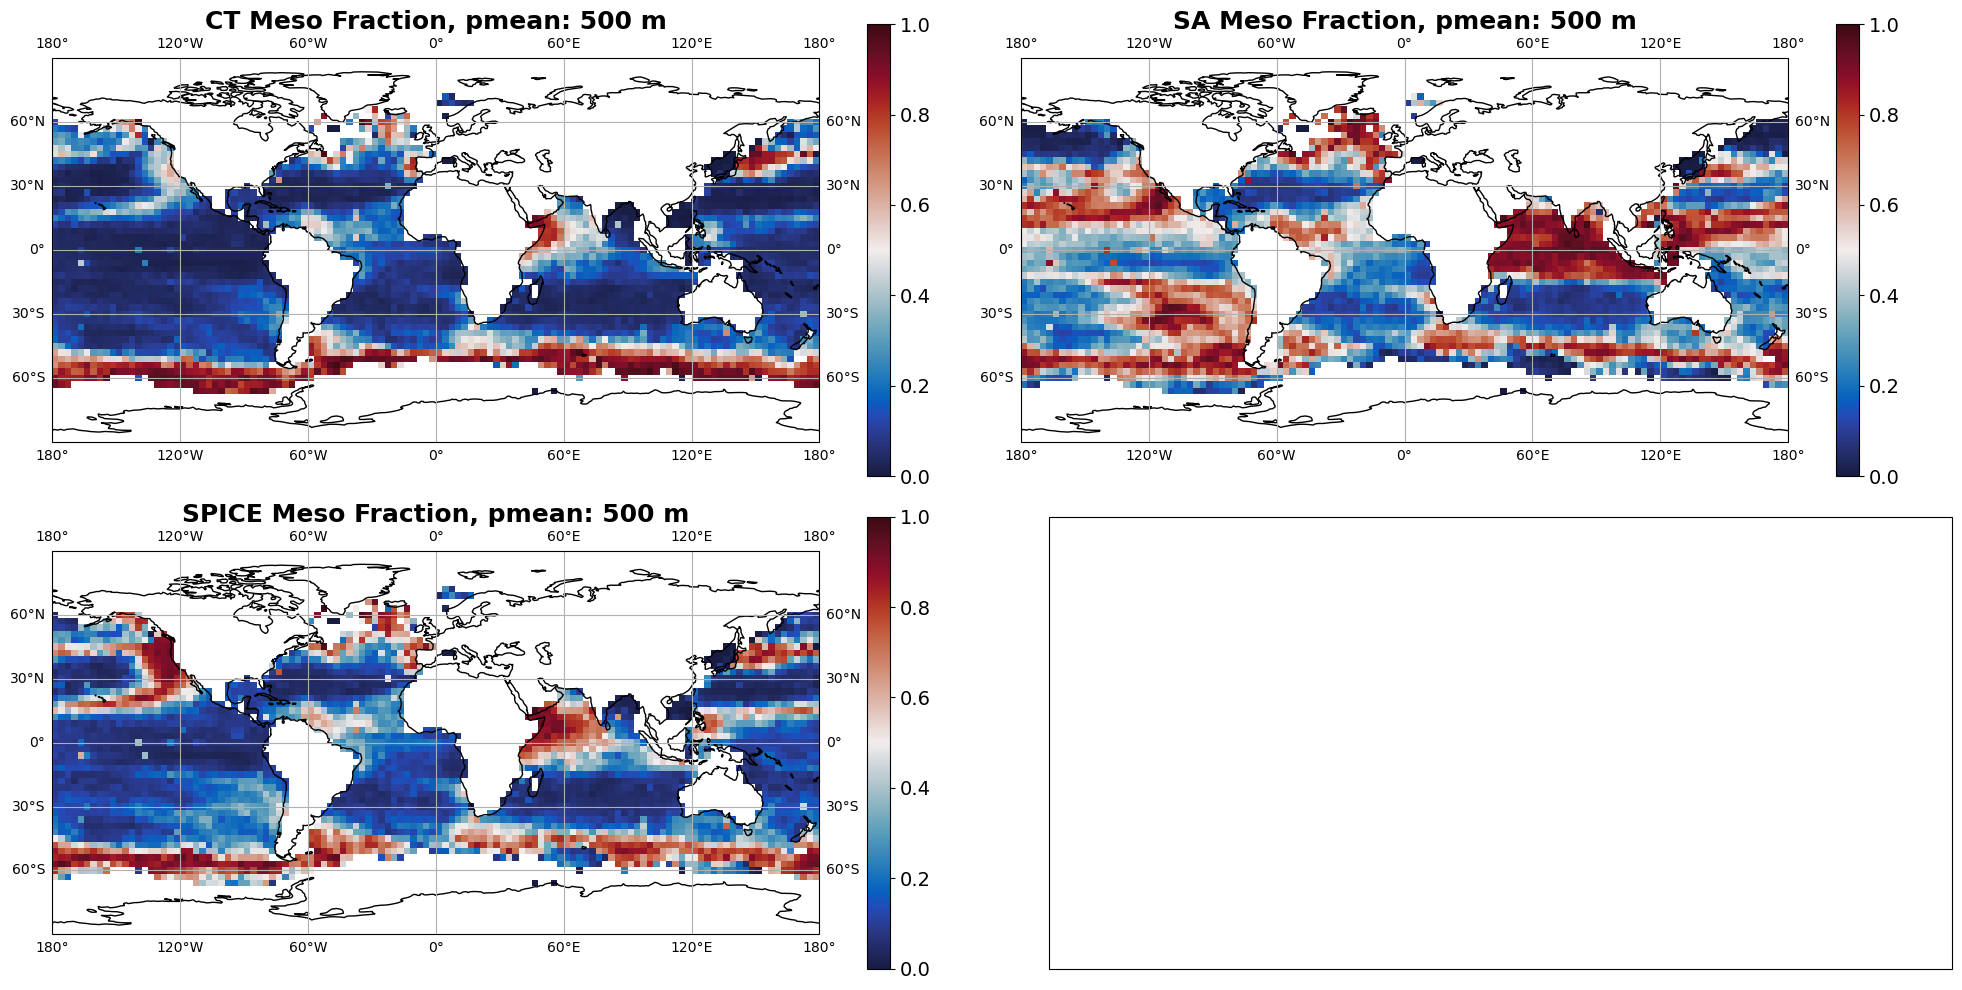

In [248]:
depth = 500

frac_cmap = cmo.balance
frac_norm = colors.Normalize(vmin=0, vmax=1)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10),subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten() # Flatten axes for easy iteration

ax = axes[0]
pmean.sel(pmean=depth, method='nearest').ct2_frac.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=frac_cmap, norm=frac_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'CT Meso Fraction, pmean: {depth} m')

ax = axes[1]
pmean.sel(pmean=depth, method='nearest').sa2_frac.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=frac_cmap, norm=frac_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SA Meso Fraction, pmean: {depth} m')

ax = axes[2]
pmean.sel(pmean=depth, method='nearest').sp2_frac.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=frac_cmap, norm=frac_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SPICE Meso Fraction, pmean: {depth} m')


plt.tight_layout()
plt.show()

## Eddy Diffusivity Maps

In [218]:
def get_grad(ds_gridded, grid, var):
    dlong = grid.diff(ds_gridded.lon, 'X')
    dlatg = grid.diff(ds_gridded.lat, 'Y', boundary='fill', fill_value=np.nan)
    
    distance_1deg_equator = 111000
    dx = dlong * np.cos(np.deg2rad(ds_gridded.lat)) * distance_1deg_equator
    dy = ((ds_gridded.lon * 0) + 1) * dlatg * distance_1deg_equator
    
    dC_dx = grid.diff(ds_gridded[var], 'X', boundary='fill', fill_value=np.nan) / dx
    dC_dy = grid.diff(ds_gridded[var], 'Y', boundary='fill', fill_value=np.nan) / dy
    
    dC_dx = grid.interp(dC_dx, ['X'], to='center', boundary='fill', fill_value=np.nan)
    dC_dy = grid.interp(dC_dy, ['Y'], to='center', boundary='fill', fill_value=np.nan)
    
    return dC_dx, dC_dy

In [213]:
ct_m_gridded, grid = get_ds_gridded(ct_m.to_dataset(name='ct_m'), lon_bins, lat_bins)
sa_m_gridded, grid = get_ds_gridded(sa_m.to_dataset(name='sa_m'), lon_bins, lat_bins)
sp_m_gridded, grid = get_ds_gridded(sp_m.to_dataset(name='sp_m'), lon_bins, lat_bins)

In [221]:
ct_m_dx, ct_m_dy = get_grad(ct_m_gridded, grid, 'ct_m')
sa_m_dx, sa_m_dy = get_grad(sa_m_gridded, grid, 'sa_m')
sp_m_dx, sp_m_dy = get_grad(sp_m_gridded, grid, 'sp_m')

In [237]:
K_e_ct = (K_rho_x*pmean.ct_var2/(ct_m_dx**2 + ct_m_dy**2)).rename('K_e_ct')
K_e_sa = (K_rho_x*pmean.sa_var2/(sa_m_dx**2 + sa_m_dy**2)).rename('K_e_sa')
K_e_sp = (K_rho_x*pmean.sp_var2/(sp_m_dx**2 + sp_m_dy**2)).rename('K_e_sp')

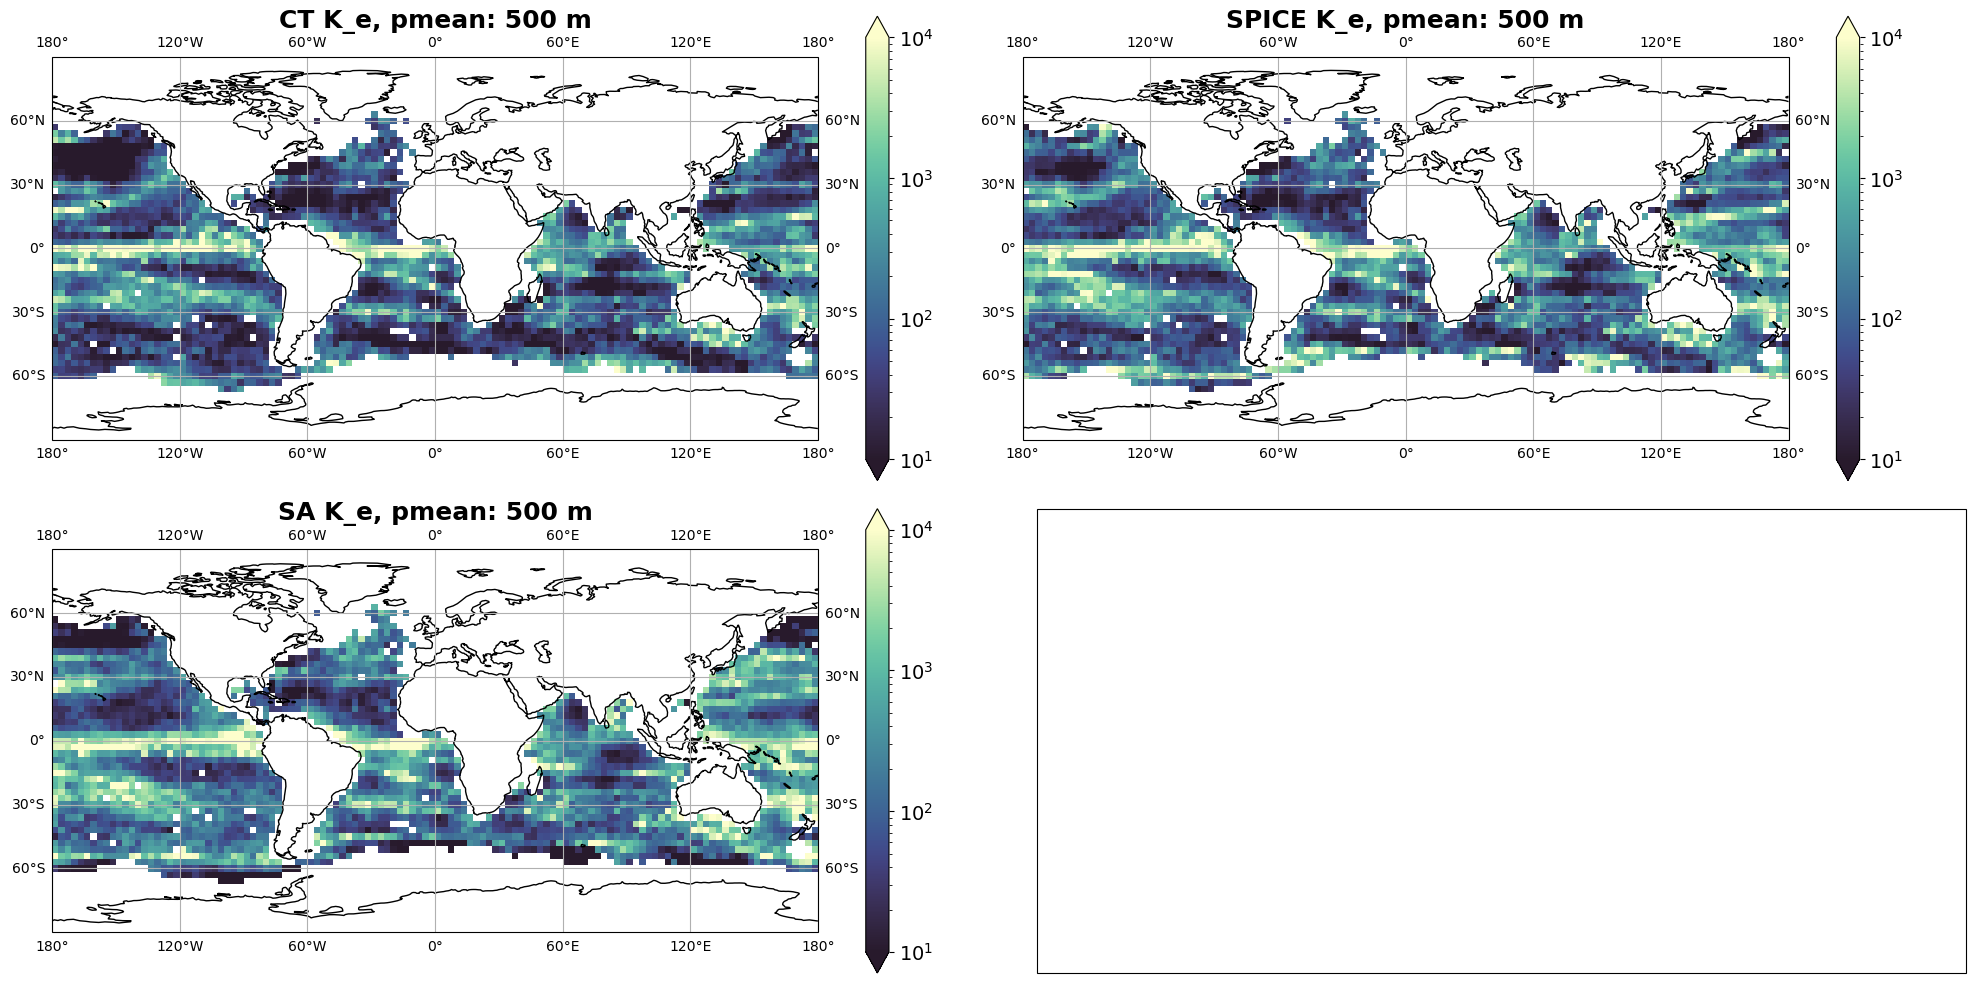

In [249]:
depth = 500

K_e_cmap = cmo.deep_r
K_e_norm = colors.LogNorm(vmin=1e1, vmax=1e4)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10),subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten() # Flatten axes for easy iteration

ax = axes[0]
pmean.sel(pmean=depth, method='nearest').K_e_ct.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=K_e_cmap, norm=K_e_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'CT K_e, pmean: {depth} m')

ax = axes[2]
pmean.sel(pmean=depth, method='nearest').K_e_sa.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=K_e_cmap, norm=K_e_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SA K_e, pmean: {depth} m')

ax = axes[1]
pmean.sel(pmean=depth, method='nearest').K_e_sp.plot(x='lon', y='lat', ax=ax, transform=ccrs.PlateCarree(), cmap=K_e_cmap, norm=K_e_norm, add_labels=False)
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ax.set_title(f'SPICE K_e, pmean: {depth} m')


plt.tight_layout()
plt.show()